# Loading the event-based version of MNIST

With Tonic you can do 2 major things:

1. Load event-based datasets
2. Add transforms to the dataset that are automatically applied every time you load a new sample.


Loading data
------------

Let's say you would like to work on N-MNIST, the neuromorphic equivalent of the popular MNIST dataset. In this dataset, a digit is displayed on screen and a neuromorphic camera in front of it executes 3 rapid sweeps in a triangular motion, as otherwise static images are not recorded with such cameras. The following animation is taken from [this repo](https://github.com/rfma23/HATS).


[<img src="https://raw.githubusercontent.com/rfma23/HATS/master/images/nmnist.gif" width="250"/> ](https://raw.githubusercontent.com/rfma23/HATS/master/images/nmnist.gif)

In [1]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=False)

Now you can index the samples manually for inspection! Depending on the dataset, you can expect different return values. N-MNIST returns events and the target class for each sample. Other datasets provide images, IMU data, GPS data and more. You will find the details in the dataset reference. Events are a structured numpy array with different channels. For recordings from event cameras, those channels are typically x, y, time and polarity.

In [2]:
events, target = dataset[1000]
events

array([(20,  7,   1112, 1), (19, 19,   1196, 1), (19, 20,   1637, 1), ...,
       (20, 25, 305468, 1), (21,  8, 305833, 1), (13, 10, 308326, 1)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

Event timestamps in Tonic will always have microsecond resolution. We can accumulate/bin many events into a frame to visualise them. That's what we're going to do next.

Applying a transform manually
-----------------------------

In [3]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)

frames = frame_transform(events)

The frames have dimensions (Time, Number of polarities, Height and Width). Let's plot one frame for each of the three saccades in a sample of N-MNIST. We'll take the difference between two camera polarities to see the direction of movement.

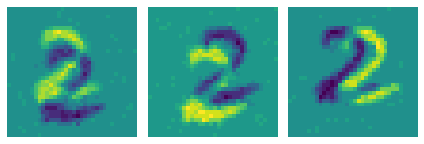

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames))
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1]-frame[0])
        axis.axis("off")
    plt.tight_layout()
        
plot_frames(frames)

You can see nicely the three saccades for this sample. The bright and dark version of the digit is because an event camera outputs two polarities, one for ON events that signify an increase in illuminance, and one for OFF events that signify a decrease.

In the previous plot we can see some isolated noise events, let's try to get rid of them. We'll use a transform that deletes such isolated events, and then apply it to our events. Notice the order we're applying. Then we are going to plot the denoised frames:

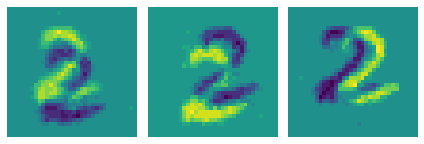

In [5]:
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

events_denoised = denoise_transform(events)
frames_denoised = frame_transform(events_denoised)

plot_frames(frames_denoised)

That looks a bit cleaner!

Converting to different representation
--------------------------------------
Conversion to frames is not the only representation that events can be transformed into. As an example, we can also plot voxel grids:

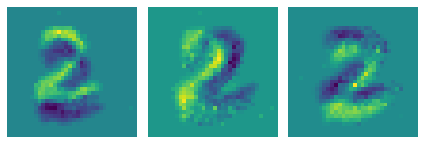

In [6]:
volume = transforms.ToVoxelGrid(sensor_size=sensor_size, n_time_bins=3)(events_denoised)

fig, axes = plt.subplots(1, len(volume))
for axis, slice in zip(axes, volume):
    axis.imshow(slice)
    axis.axis("off")
plt.tight_layout()

Or time surfaces:

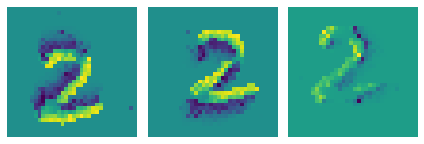

In [7]:
surfaces = transforms.ToTimesurface(sensor_size=sensor_size, surface_dimensions=None, tau=10000, decay='exp')(events_denoised)

n_events = events_denoised.shape[0]
n_events_per_slice = n_events // 3
fig, axes = plt.subplots(1, 3)
for i, axis in enumerate(axes):
    surf = surfaces[(i+1)*n_events_per_slice - 1]
    axis.imshow(surf[0] - surf[1])
    axis.axis("off")
plt.tight_layout()

Putting it all together
-----------------------
Previously we applied the transformations manually. We can simplify this code, by chaining the transforms and passing them to our dataset.

In [8]:
transform = transforms.Compose([denoise_transform, frame_transform])

dataset = tonic.datasets.NMNIST(save_to='./data',
                                train=False,
                                transform=transform)

Now the transforms will be applied whenever a new sample is loaded. To simplify the loading, we make use of a PyTorch DataLoader in a final step:

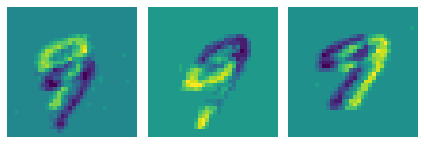

In [9]:
import torch
torch.manual_seed(1234)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True)
frames, target = next(iter(dataloader))

plot_frames(frames.squeeze())

And that's there is to it!